In [1]:
import sys
from pathlib import Path
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from engine.data_loader import load_fred_series
from engine.geometry.mass_inputs import load_mass_fields, load_calm_mass_fields
from engine.geometry.stress_energy import build_stress_energy
from engine.geometry.curvature import map_curvature
from engine.geometry.gravity import build_gravity

from engine.core.reactor import run_reactor
from engine.calm.refinery import run_calm_refinery
from engine.calm.pnl import calm_pnl
from engine.portfolio import route_capital
from reports.gravity_reports import build_event_table


In [3]:
# Build gravity field
funding, collateral, liquidity = load_mass_fields()
T = build_stress_energy(funding, collateral, liquidity)
C = map_curvature(T)
G = build_gravity(C)

# Market
price = load_fred_series("SP500")["SP500"].dropna()
returns = price.pct_change().dropna()


In [4]:
# Leg-1
pnl_leg1 = run_reactor(returns, G)

# Leg-2
calm_exposure = run_calm_refinery(G)
pnl_leg2 = calm_pnl(calm_exposure, price)

# Total
portfolio_pnl = route_capital(pnl_leg1, pnl_leg2)


In [5]:
eq_leg1 = (1 + pnl_leg1.fillna(0)).cumprod()
eq_leg2 = (1 + pnl_leg2.fillna(0)).cumprod()
eq_total = (1 + portfolio_pnl.fillna(0)).cumprod()


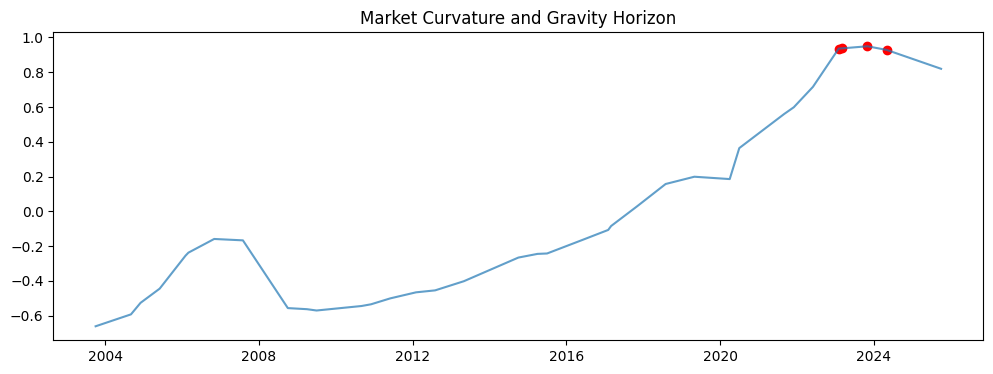

In [6]:
plt.figure(figsize=(12,4))
plt.plot(C, alpha=0.7)
plt.scatter(G[G==1].index, C[G==1], color="red")
plt.title("Market Curvature and Gravity Horizon")
plt.show()


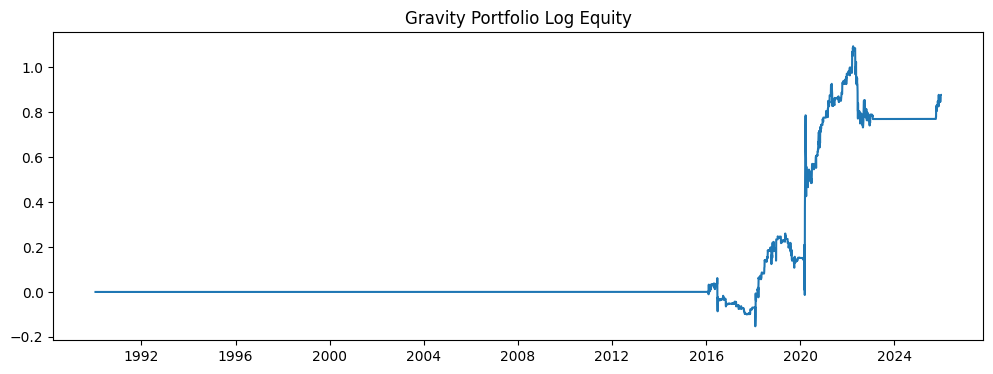

In [7]:
plt.figure(figsize=(12,4))
plt.plot(np.log(eq_total))
plt.title("Gravity Portfolio Log Equity")
plt.show()


In [8]:
events = build_event_table(C, G, returns, pnl_leg1)
events.tail()


,curvature,gravity,returns,pnl
date,,,,
2023-02-01,0.936136,1.0,0.010452,0.000214
2023-03-01,0.937160,1.0,-0.004725,0.000009
2023-11-01,0.949247,1.0,0.010506,0.000042
2024-05-01,0.928431,1.0,-0.003435,0.000247


In [ ]:
clock = eq_total.index

eq_leg1_m = eq_leg1.reindex(clock).ffill().fillna(1.0)
eq_leg2_m = eq_leg2.reindex(clock).ffill().fillna(1.0)


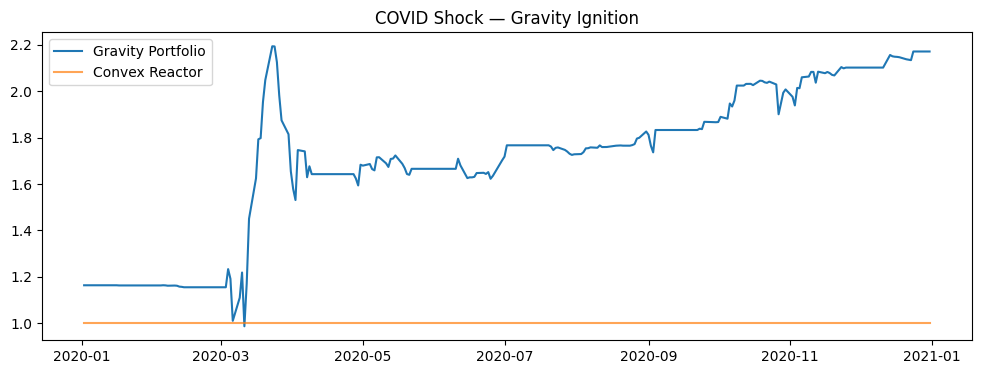

In [13]:
w = (clock >= "2020-01-01") & (clock <= "2020-12-31")

plt.figure(figsize=(12,4))
plt.plot(eq_total.loc[w], label="Gravity Portfolio")
plt.plot(eq_leg1_m.loc[w], label="Convex Reactor", alpha=0.7)
plt.title("COVID Shock — Gravity Ignition")
plt.legend()
plt.show()


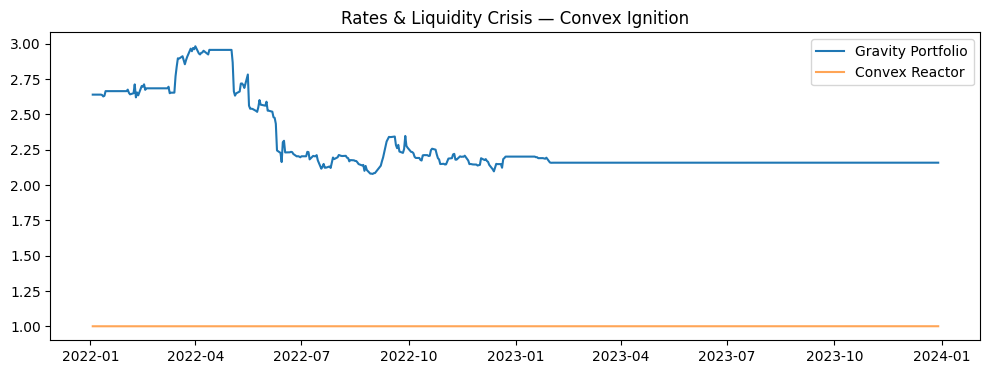

In [14]:
w = (clock >= "2022-01-01") & (clock <= "2023-12-31")

plt.figure(figsize=(12,4))
plt.plot(eq_total.loc[w], label="Gravity Portfolio")
plt.plot(eq_leg1_m.loc[w], label="Convex Reactor", alpha=0.7)
plt.title("Rates & Liquidity Crisis — Convex Ignition")
plt.legend()
plt.show()
